In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -q /content/drive/MyDrive/mushroom_project/Muchrooms12.zip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import classification_report

assert tf.__version__.startswith('2')

from tflite_model_maker import configs
from tflite_model_maker import ExportFormat
from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker import model_spec

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/Muchrooms12') 

BATCH_SIZE = 32
IMG_SIZE = (224, 224) 

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

In [ ]:
class_names = train_dataset.class_names
print(class_names)

In [ ]:
plt.figure(figsize=(14, 14))
for images, labels in train_dataset.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# หมุนภาพ
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset= -1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
# https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=th
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, 
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
# default
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(12) 
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
#input
inputs = tf.keras.Input(shape=(224, 224, 3)) #change depend on your model that you use 

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x) 

#output
outputs = prediction_layer(x)

#model
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

#if val_accuracy > accuracy = Overfitting

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
#Training and Validation Accuracy: เส้นสีส้ม must under the blue line

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
fine_tune_epochs2 = 10 
total_epochs =  fine_tune_epochs + fine_tune_epochs2

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

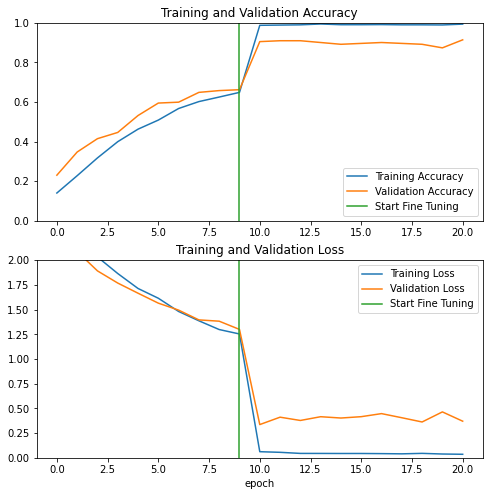

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset) # *test_dataset only
#loss, accuracy = model.evaluate(validation_dataset)

print('Test accuracy :', accuracy)

In [ ]:
model_name = 'keras_pretrained_mushroom12_model.h5'
model_path = os.path.join('/content/drive/MyDrive/mushroom_project/mushrooms12_h5_pretrain_model/', model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


Russula_emetica(Poisonous) with a 99.54% confidence.


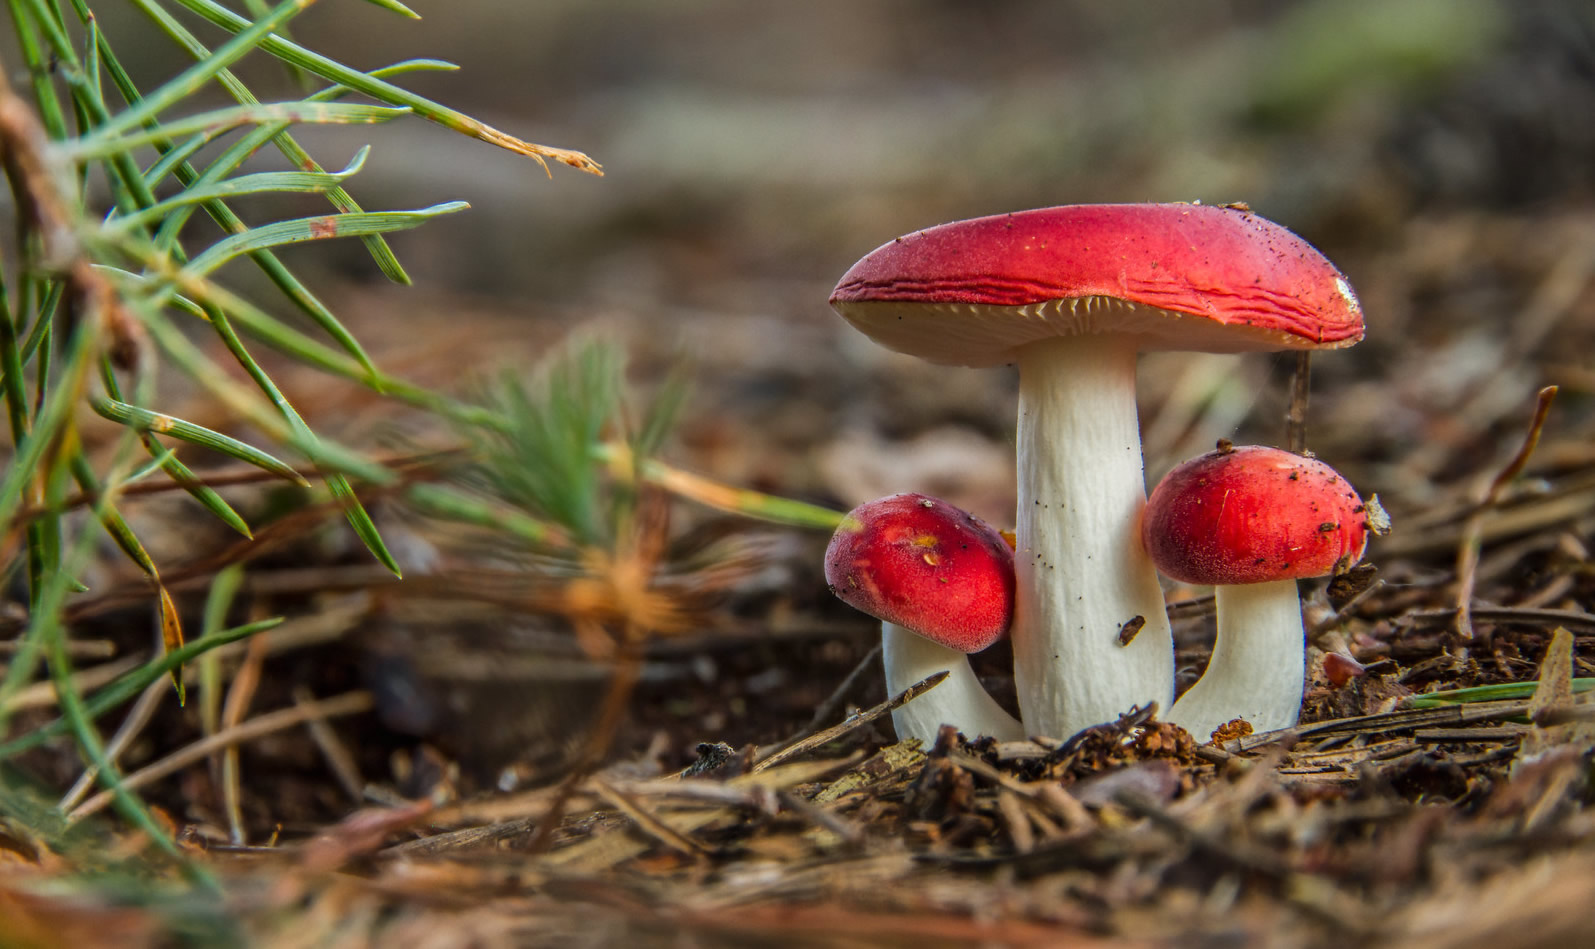

In [ ]:
# to make predictions
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing import image
path_img = '/content/drive/MyDrive/mushroom_project/test/12.jpg'
test_image = image.load_img(path_img, target_size = (224, 224)) 

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

# load Model
from keras.models import load_model

model_name = 'keras_pretrained_mushroom12_model.h5' # change
model_path = os.path.join('/content/drive/MyDrive/mushroom_project/mushrooms12_h5_pretrain_model/', model_name) #change
model = load_model(model_path)

result = model.predict(test_image)
score = tf.nn.softmax(result[0])
print("{} with a {:.2f}% confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

from IPython.display import Image
Image(path_img)

In [ ]:
# convert model to tflite
tflite_model = tf.keras.models.load_model('/content/drive/MyDrive/mushroom_project/mushrooms12_h5_pretrain_model/keras_pretrained_mushroom12_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("/content/drive/MyDrive/mushroom_project/mushrooms12_tflite_model/MushroomModel.tflite", "wb").write(tflite_save)

In [ ]:
y_pred = model.predict(validation_dataset)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in validation_dataset], axis=0)

report = classification_report(true_categories, predicted_categories, target_names=class_names)
print(report) 

                                        precision    recall  f1-score   support

         Amanita_pantherina(Poisonous)       0.00      0.00      0.00        17
         Amanita_phalloides(Poisonous)       0.00      0.00      0.00        14
       Coltricia perennis(NoPoisonous)       0.08      0.12      0.10         8
  Lactarius flavidulus_Imai(Poisonous)       0.21      0.14      0.17        21
         Lentinula_edodes(NoPoisonous)       0.12      0.12      0.12        17
         Psilocybe_cubensis(Poisonous)       0.14      0.14      0.14        21
            Russula_emetica(Poisonous)       0.20      0.21      0.21        19
 Termitomyces_fuliginosus(NoPoisonous)       0.15      0.11      0.13        18
Thaeogyroporus_porentosus(NoPoisonous)       0.14      0.14      0.14        22
       Volvariella_volvacea(Poisonous)       0.05      0.07      0.06        15
   chlorophyllum_molybdites(Poisonous)       0.20      0.15      0.17        27
    hygroscopic_earthstar(NoPoisonous) 